# Fine Tuning and Guidance

In this notebook we will explore the following: 
1. Creating a sampling loop and generate examples faster using a new scheduler
2. FIne tuning an existing diffusion model using new data
3. Guide the sampling process with additional loss functions to add control over existing models, including:
    - Exploring different guidnace approaches with a simple color-based loss
    - Using CLIP to guide generation using a text prompt

## Set Up

In [1]:
%pip install -qq diffusers datasets accelerate wandb open-clip-torch

Note: you may need to restart the kernel to use updated packages.


In [2]:
!git config --global credential.helper store

In [3]:
# Logging in to hugging face using tokens
from huggingface_hub import notebook_login

notebook_login()

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

2024-07-28 02:57:28.064106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-28 02:57:28.064230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-28 02:57:28.193896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
device

'cuda'

### Loading a Pre Trained Pipeline

In [7]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.29.2",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

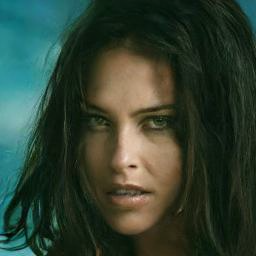

In [8]:
images = image_pipe().images
images[0]

The above sampling loop is very slow, the pope is defined to go over a 1000 steps before we generate the image. We need to see how to speed it up.

### Faster Sampling with DDIM

At every step, the model is fed a noisy input and asked to predict the noise. Initially these predictions are not very god, which is why we break the process down into many steps. However using 1000+ steps has been found to be unnecesary. Interesting!

In the diffusers library these sampling methods are handled by a scheduler, which must perform each update via the `step()` function. 

In the above example we saw that we performed inference over a 1000 steps, but we can achieve this with lesser numebr of steps. 

In [9]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

In [10]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

Here we see that the model does 40 steps in total with a jump of 25 steps instead of the initial 1000. Lets create 4 random images and run through the sampling loop, viewing both the current image and the predicted deionized version as the process progresses: 

In [14]:
def observe(): 
    # The random starting point
    x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

    # Loop through the sampling timesteps
    # tqdm is a Python library used to display progress bars in loops.
    # 40 steps, index, step number
    for i , t in tqdm(enumerate(scheduler.timesteps)):

        # Prepare model input
        # Append noise to the model to prepare the input to 
        # represent the input with the exact amount of noise at time step t
        # the input is dependent on x
        model_input = scheduler.scale_model_input(x, t)

        # Get the predicted noise
        with torch.no_grad():
            noise_pred = image_pipe.unet(model_input, t)["sample"]

        # Calculate what the updated sample should look like with the scheduler
        # based on the predicted noise
        scheduler_output = scheduler.step(noise_pred, t, x)

        # Scheduler says how the input would be after the denoising happens
        # so we update x to that now
        # Since we are going in the reverse, from noise to image, we use 
        # `prev_sample`
        x = scheduler_output.prev_sample

        # Occasionall display both x and the predicted denoised images
    #     if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
    #         fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    #         grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
    #         axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
    #         axs[0].set_title(f"Current x (step {i})")

    #         pred_x0 = scheduler_output.pred_original_sample  # Not available for all schedulers
    #         grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
    #         axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
    #         axs[1].set_title(f"Predicted denoised images (step {i})")
    #         plt.show()

        # Occasionall display both x, noise component, and the predicted denoised images
        if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
            fig, axs = plt.subplots(1, 3, figsize=(18, 5))

            # Current noisy image
            grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
            axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[0].set_title(f"Current x (step {i})")

            # Noise component (the part that is subtracted)
            noise_component = x - scheduler_output.pred_original_sample
            grid = torchvision.utils.make_grid(noise_component, nrow=4).permute(1, 2, 0)
            axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[1].set_title(f"Noise component (step {i})")

            # Predicted denoised images
            pred_x0 = scheduler_output.pred_original_sample  # Not available for all schedulers
            grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
            axs[2].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
            axs[2].set_title(f"Predicted denoised images (step {i})")

            plt.show()

0it [00:00, ?it/s]

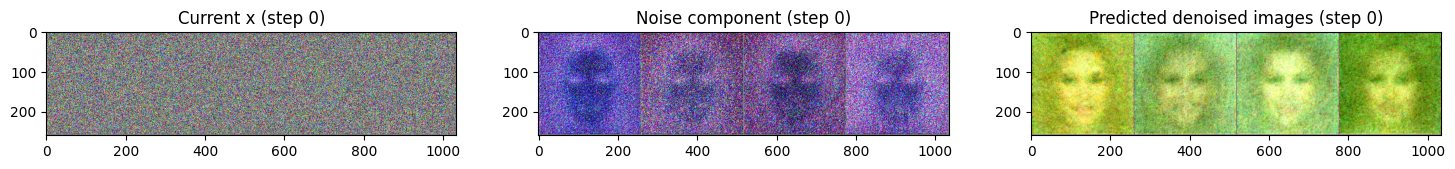

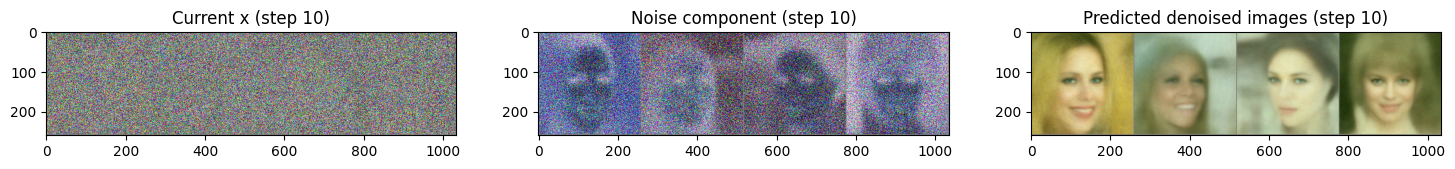

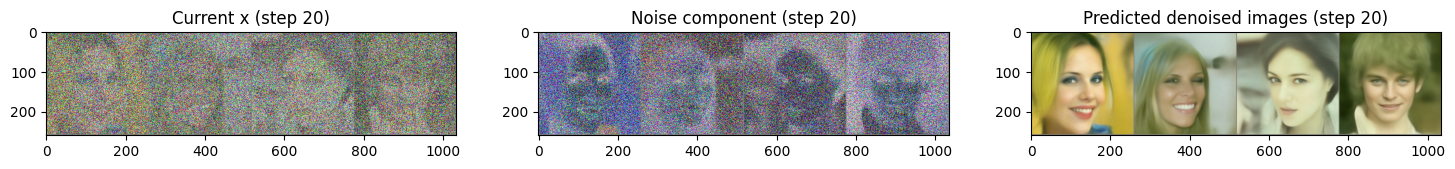

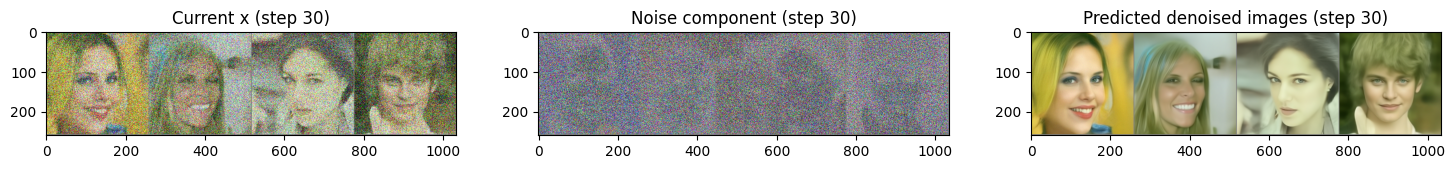

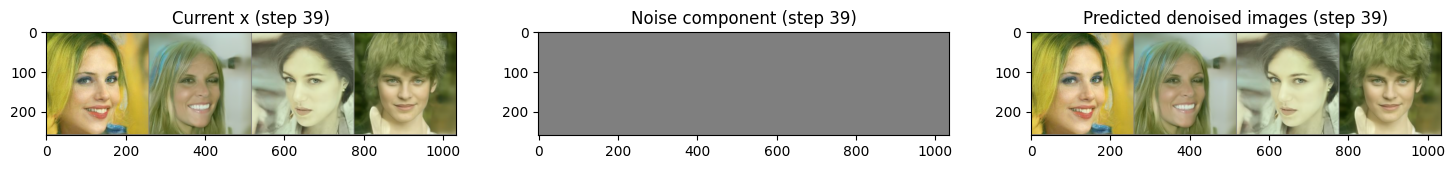

In [15]:
observe()

0it [00:00, ?it/s]

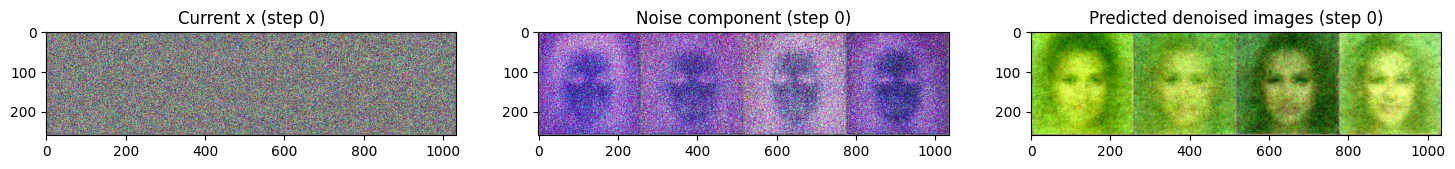

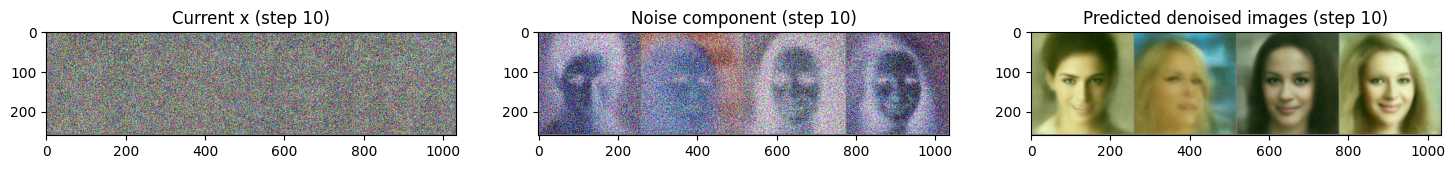

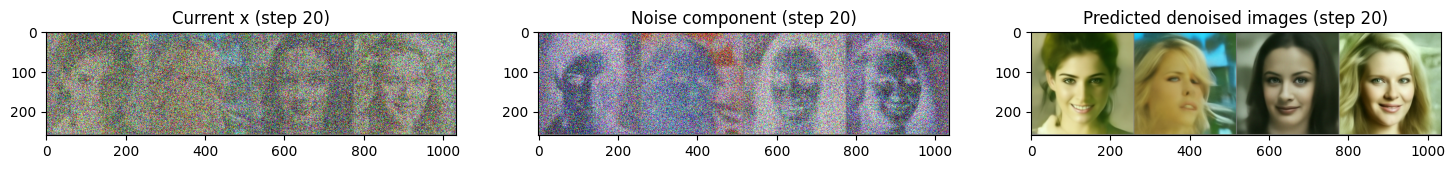

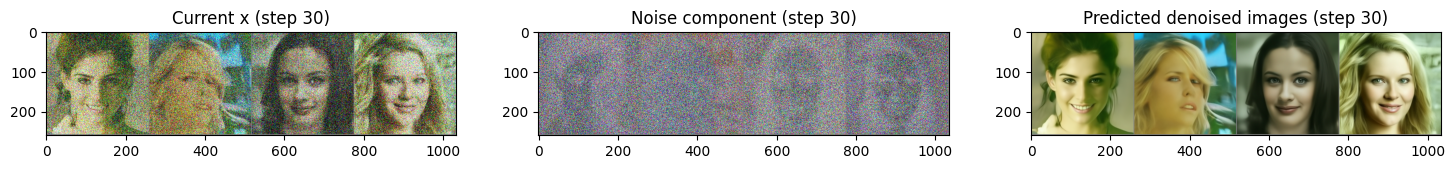

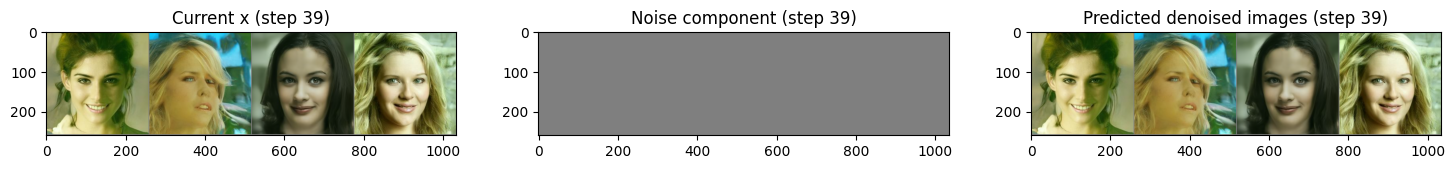

In [16]:
observe()

0it [00:00, ?it/s]

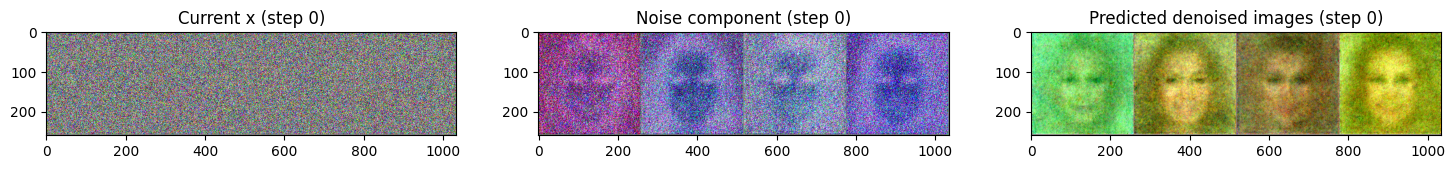

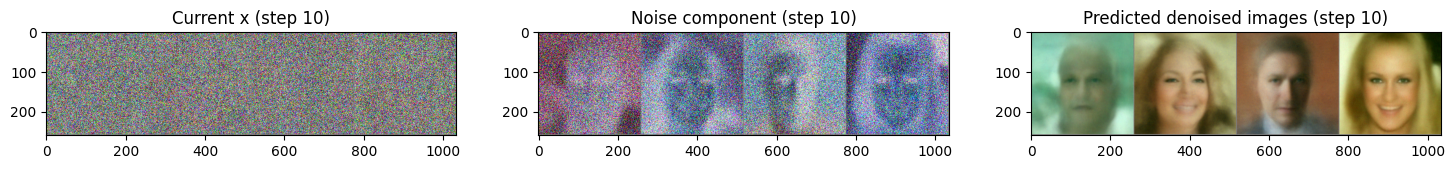

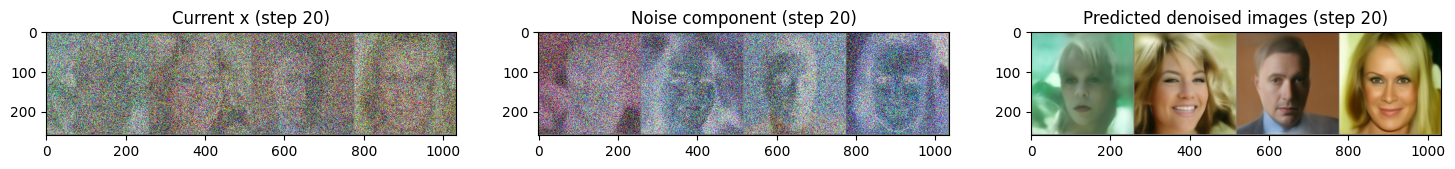

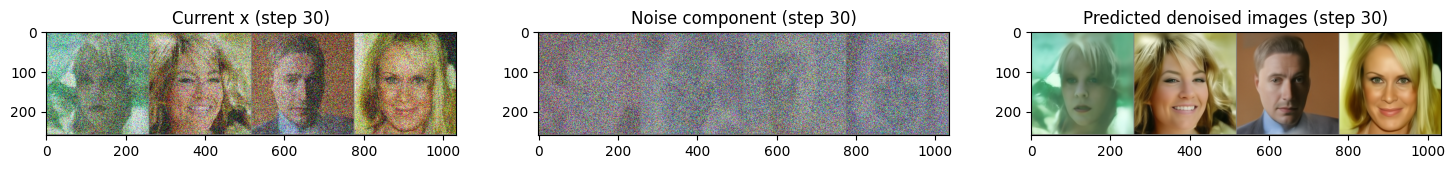

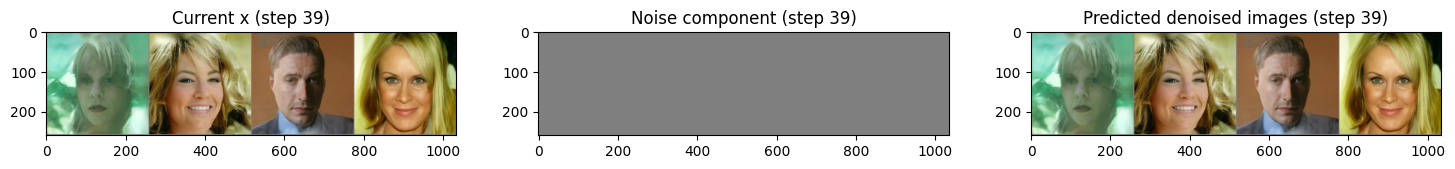

In [17]:
observe()

### Using this updated scheduler for image generation with faster interpretation

  0%|          | 0/40 [00:00<?, ?it/s]

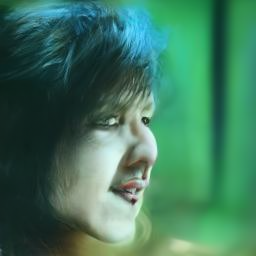

In [18]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

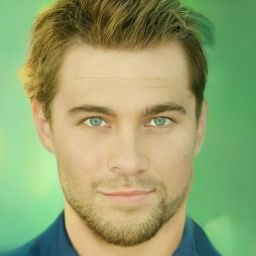

In [19]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

  0%|          | 0/40 [00:00<?, ?it/s]

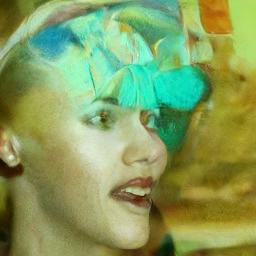

In [20]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

## Fine-tuning

Given this pre-trained pipeline, how might we re-train the model to generate images based on new training data ?

This is nearly identical to training a model from scratch, except that here we begin with an existing model.

Let's try using the butterfly dataset that we used in one of the previous notebooks.

In [22]:
dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [23]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Previewing batch:


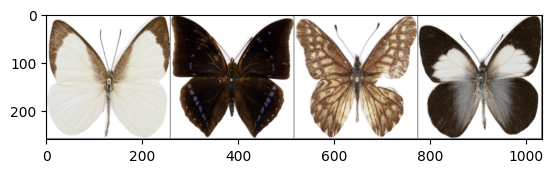

In [ ]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [33]:
def format_params(model):

    # Calculate the total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    # Format the total number of parameters in a human-readable format
    if total_params >= 1e9:
        readable_params = f"{total_params / 1e9:.2f} Billion"
    elif total_params >= 1e6:
        readable_params = f"{total_params / 1e6:.2f} Million"
    elif total_params >= 1e3:
        readable_params = f"{total_params / 1e3:.2f} Thousand"
    else:
        readable_params = str(total_params)

    print(f"Total number of parameters in the model: {readable_params}")

In [34]:
format_params(image_pipe.unet)

Total number of parameters in the model: 113.67 Million


**Checking the params in our previous model**

In [30]:
image_pipe_prev = DDPMPipeline.from_pretrained("DhruvParth/sd-class-skinrash-64")

model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [35]:
format_params(image_pipe_prev.unet)

Total number of parameters in the model: 18.54 Million


*Inference: the parameters in the model that I used earlier was very low, so that could be one of the reasons why the performance was so bad*

Refer [Gif of Previous Expriment](https://private-user-images.githubusercontent.com/113069126/352765547-55a51acb-ff1b-4b11-b4df-59379d25aaac.gif?jwt=eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmF3LmdpdGh1YnVzZXJjb250ZW50LmNvbSIsImtleSI6ImtleTUiLCJleHAiOjE3MjIxNDA5MTQsIm5iZiI6MTcyMjE0MDYxNCwicGF0aCI6Ii8xMTMwNjkxMjYvMzUyNzY1NTQ3LTU1YTUxYWNiLWZmMWItNGIxMS1iNGRmLTU5Mzc5ZDI1YWFhYy5naWY_WC1BbXotQWxnb3JpdGhtPUFXUzQtSE1BQy1TSEEyNTYmWC1BbXotQ3JlZGVudGlhbD1BS0lBVkNPRFlMU0E1M1BRSzRaQSUyRjIwMjQwNzI4JTJGdXMtZWFzdC0xJTJGczMlMkZhd3M0X3JlcXVlc3QmWC1BbXotRGF0ZT0yMDI0MDcyOFQwNDIzMzRaJlgtQW16LUV4cGlyZXM9MzAwJlgtQW16LVNpZ25hdHVyZT1lZWJjMzYwZGQxZTk5MjYyYzkxNjdhYWJiOWU2NmIzMjFlZjViYzdiODM2YjEyMTExYjRmNWUyMTZlYTkxODk4JlgtQW16LVNpZ25lZEhlYWRlcnM9aG9zdCZhY3Rvcl9pZD0wJmtleV9pZD0wJnJlcG9faWQ9MCJ9.6kXXbC67bEkf4qyEEsY2UKCJJRgvwOWqjUMJGT2MUzQ)

### Considerations

#### Consideration 1 : 
Our batch size here is 4 which is pretty small. Since we're training at a large image size (256px) using a faily large model, we will run out of GPU RAM if we push the batch size too high. We can reduce the image size to speed things up and allow for larger batches, however these models were designed and originally trained for `256px generation`.

For the training loop, we'll update the weights of the pre-trained model by setting the optimization target to `image_pipe.unet.parameters()`

> When you set the optimization target to image_pipe.unet.parameters(), you are telling the optimizer which parameters (weights and biases) it should update during the training process. This is done by passing the parameters of the UNet model to the optimizer.

> During each iteration of the training loop, the optimizer updates the model parameters to minimize the loss. These updates are based on the gradients calculated during the backward pass. By setting the target to image_pipe.unet.parameters(), the optimizer specifically updates the weights of the UNet model.

  0%|          | 0/250 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.015080470697372221


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.013100304603693075


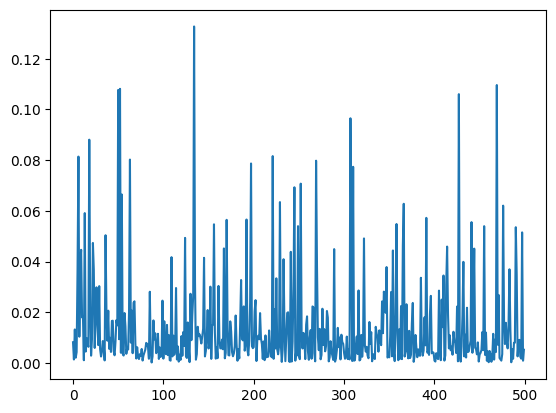

In [36]:
num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param

# Setting the optimization target to the model parameters
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)

#### Consideration 2: 

The Loss signal is extremely noisy: `Since we are only working with 4 examples at random noise levels for each step, this is not ideal for training.`

*One fix is to use extremely low learning rate to limit the size of the update in each step.* 

It would be even better if we could find some way to get the same benefit we could from using larger batch size `without` the memory requirements skyrocketing...

**Enter Gradient Accumulation**: If we call `loss.backward()` multiple times before running `optimizer.step()`, then PyTorch accumulates (sums) the gradients, effectively merging the signal from sevearl batches to give a sigle (better) estimate which is then used to update the parameters. 

This results in fewer total updates being made. This is something that many frameworks handle for us.

### Finding the ideal batch size

In [39]:
def get_max_batch_size(model, initial_batch_size, image_size, device, memory_limit):
    batch_size = initial_batch_size
    while True:
        try:
            # Generate dummy data
            images = torch.randn(batch_size, 3, image_size, image_size).to(device)
            timesteps = torch.randint(0, model.scheduler.num_train_timesteps, (batch_size,), device=device).long()
            noise = torch.randn(images.shape).to(device)
            noisy_images = model.scheduler.add_noise(images, noise, timesteps)

            # Forward pass
            model.unet(noisy_images, timesteps, return_dict=False)
            torch.cuda.empty_cache()  # Clear cache to monitor actual memory usage
            print(f"Batch size {batch_size} fits in memory.")
            batch_size += 1  # Increment batch size
        except RuntimeError as e:
            print(f"Batch size {batch_size} exceeds memory limit.")
            batch_size -= 1  # Use the last successful batch size
            break
    return batch_size

initial_batch_size = 4
image_size = 256
memory_limit = 16 * 1024  # 15 GB in MB

max_batch_size = get_max_batch_size(image_pipe, initial_batch_size, image_size, device, memory_limit)
print(f"Max batch size: {max_batch_size}")

Batch size 4 fits in memory.
Batch size 5 fits in memory.
Batch size 6 fits in memory.
Batch size 7 exceeds memory limit.
Max batch size: 6


In [40]:
torch.cuda.empty_cache() 

### Isolating and Explaining Changes for Gradient Accumulation

To enable gradient accumulation, a few specific changes can be made to the original training loop. Here are those changes isolated and explained:

#### Changes for Gradient Accumulation

1. **Adjusted Learning Rate**:
   ```python
   adjusted_lr = lr / grad_accumulation_steps
   optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=adjusted_lr)
   ```
   
   - The learning rate is adjusted by dividing it by the number of gradient accumulation steps. This is crucial because with gradient accumulation, each optimizer step effectively incorporates more gradient information, similar to having a larger batch size.

2. **Backpropagation and Gradient Accumulation**:
   ```python
   loss.backward()
   ```
   - Instead of updating the model parameters after every single batch, `loss.backward()` accumulates the gradients over multiple batches.

3. **Optimizer Step and Zero Gradients**:
   ```python
   if (step + 1) % grad_accumulation_steps == 0:
       optimizer.step()
       optimizer.zero_grad()
   ```
   
   - The condition `(step + 1) % grad_accumulation_steps == 0` checks if the current step is at the interval where the gradients should be applied to update the model parameters.
   
   - `optimizer.step()` updates the model parameters based on the accumulated gradients.
   
   - `optimizer.zero_grad()` resets the gradients, so they do not accumulate beyond the intended number of steps.

#### Difference in the Changed Approach

**Without Gradient Accumulation**:
- Each batch directly contributes to the gradient calculation, and the optimizer updates the model parameters after every batch. This approach is straightforward but can be limited by GPU memory constraints, especially with large batch sizes or large models.

**With Gradient Accumulation**:
- Gradients are accumulated over multiple batches before updating the model parameters. This allows the effective batch size to be larger than what would normally fit in GPU memory.
- The learning rate is adjusted to account for the larger effective batch size, ensuring stable training dynamics.

### Updating batch size and implementing graduent accumulation

Previewing batch:


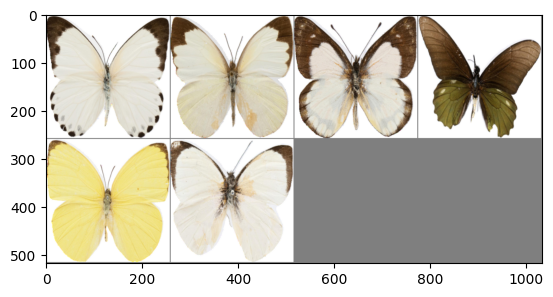

In [ ]:
batch_size = 6  # @param

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 0 average loss: 0.013897369506986376


  0%|          | 0/167 [00:00<?, ?it/s]

Epoch 1 average loss: 0.011618544656224269


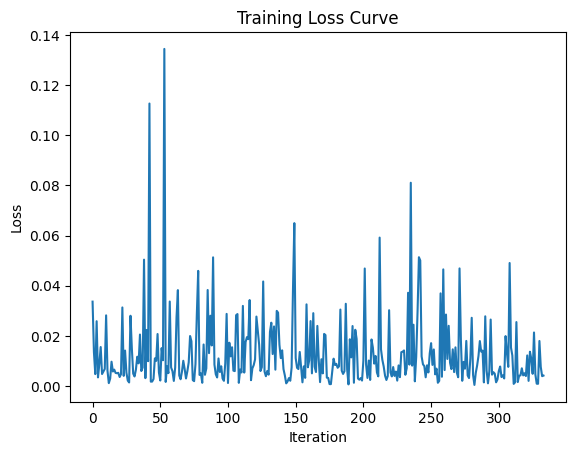

In [43]:
num_epochs = 2  # @param
lr = 1e-5  # @param
grad_accumulation_steps = 2  # @param

# Adjust the learning rate based on the number of gradient accumulation steps
adjusted_lr = lr / grad_accumulation_steps

# Setting the optimization target to the model parameters
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=adjusted_lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(noise_pred, noise)  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Backpropagation with gradient accumulation
        loss.backward()

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Print the average loss for the epoch
    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):]) / len(train_dataloader)}")

# Plot the loss curve:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

***We notice that there is less noise in the training loss signal***

0it [00:00, ?it/s]

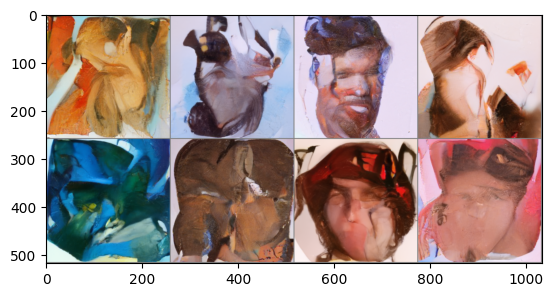

In [ ]:
# @markdown Generate and plot some images:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

Generating some images with this model, we can see that these faces are already looking mighty strange!

Is it because we fine tuned a face generator model with images of butterflies ?

### Consideration 4: 

Fine-tuning can be quite unpredictable! If we trained for a lot longer, we might see some perfect butterflies. But the intermediate steps can be extremely interesting in their own right, especially if your interests are more towards the artistic side! 

> TODO: Explore training for very short or very long periods of time, and varying the learning rate to see how this affects the kinds of output the final model produces.